In [1]:
%matplotlib inline
import sys
sys.path.append("..")

## 1. Setup

Imports needed for this tutorial.

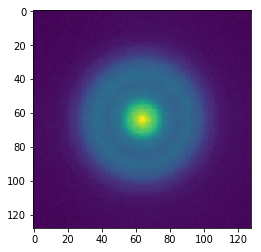

In [56]:
import numpy as np
import matplotlib.pyplot as plt

from deeptrack.scatterers import Ellipse
from deeptrack.optics import Fluorescence
from deeptrack.noises import Poisson, Offset
from deeptrack.aberrations import SphericalAberration

from deeptrack.models import convolutional
from deeptrack.generators import Generator

## 2. Defining the features

We define the features needed for this example. 

* optics - Flourescence microscope with a pixel size of 0.1 microns and a 128x128 camera
* particle - Spherical particle roughly centered in the image, a micron out of focus
* aberration - Spherical aberration with a coefficient between -4 and 4
* noise - A constant background illumantion and a poisson noise with signal to noise ratio of 100
* normalization - Maps the image to values between 0 and 1.

In [83]:
optics = Fluorescence(
    magnification=10,
    resolution=1e-6,
    wavelength=633e-9,
    output_region=(0, 0, 128, 128)
)

particle = Ellipse(
    position=lambda: np.random.randn(3) * [1, 1, 3] + (64, 64, 10),
    position_unit="pixel",
    intensity=10,
    radius=np.random.rand()*1e-6 + 0.5e-6,
)

aberration = SphericalAberration(coefficient=lambda: (np.random.rand() - 0.5) * 8)

noise = Offset(offset=0.01) + Poisson(snr=100)

normalization = NormalizeMinMax(min=0, max=1)

aberrated_particle = optics(particle, aberration) + noise + normalization

## 3. Combining the features

To view the particle throught the aberrated microscope, we call `optics` with both the particle and the aberration. Then we add the noise and normalization as usual.

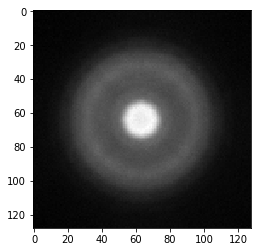

In [110]:
aberrated_particle = optics(particle, aberration) + noise + normalization

aberrated_particle.plot(cmap="gray")

## 4. Defining the label function and the generator

We define a label function that iterates through all the properties and returns the coefficient of the SphericalAberration.

In [112]:
def get_aberration(image):
    for prop in image.properties:
        if prop["name"] == "SphericalAberration":
            return prop["coefficient"]

generator = Generator().generate(aberrated_particle, get_aberration, batch_size=32)



## 5. Creating the model

We will use a standard convolution model for this task. Since this is a regression task, we will use mean absolute error as loss.

In [113]:
model = convolutional(input_shape=(128, 128, 1), number_of_outputs=1)
model.compile(optimizer='rmsprop', loss='mae', metrics=['mse', 'mae'])

## 6. Training the model

We train the model for 100 epochs.

In [67]:
model.fit(generator, epochs=100, steps_per_epoch=20)

Epoch 1/100
20/20 [==============================] - 13s 631ms/step - loss: 1.9821 - mean_squared_error: 5.3943 - mean_absolute_error: 1.9821
Epoch 2/100
20/20 [==============================] - 13s 632ms/step - loss: 1.9659 - mean_squared_error: 5.2258 - mean_absolute_error: 1.9659
Epoch 3/100
20/20 [==============================] - 12s 622ms/step - loss: 1.9710 - mean_squared_error: 5.5322 - mean_absolute_error: 1.9710
Epoch 4/100
20/20 [==============================] - 13s 628ms/step - loss: 1.9077 - mean_squared_error: 6.1356 - mean_absolute_error: 1.9077
Epoch 5/100
20/20 [==============================] - 13s 643ms/step - loss: 1.9051 - mean_squared_error: 6.6927 - mean_absolute_error: 1.9051
Epoch 6/100
20/20 [==============================] - 13s 655ms/step - loss: 1.8514 - mean_squared_error: 5.6507 - mean_absolute_error: 1.8514
Epoch 7/100
20/20 [==============================] - 13s 651ms/step - loss: 1.7942 - mean_squared_error: 5.8747 - mean_absolute_error: 1.7942
Epoch 

## Validating the result

Finally we validate the result by plotting the predicted value against the true value.

Text(0.5, 1.0, 'Spherical aberration coefficient')

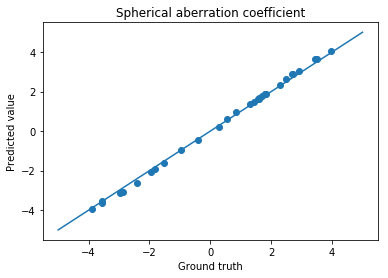

In [69]:
batch, labels = next(generator)

prediction = model.predict(batch)

plt.scatter(labels, prediction)
plt.plot([-5, 5], [-5, 5])
plt.xlabel("Ground truth")
plt.ylabel("Predicted value")
plt.title("Spherical aberration coefficient")
    